In [ ]:
# Project 4: Gaussian Processes and Kernel Methods (Sheikh Islam, Wilson Jimenez, & Talha Akhlaq)

# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score

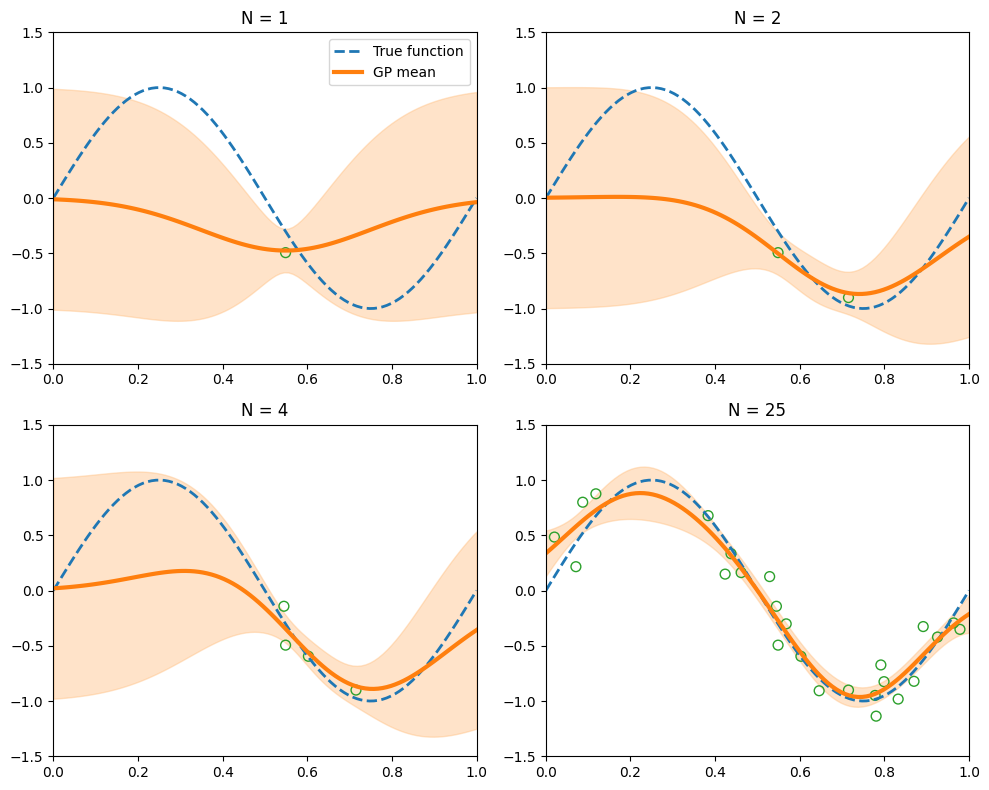

Synthetic SVM accuracy: 93.33%


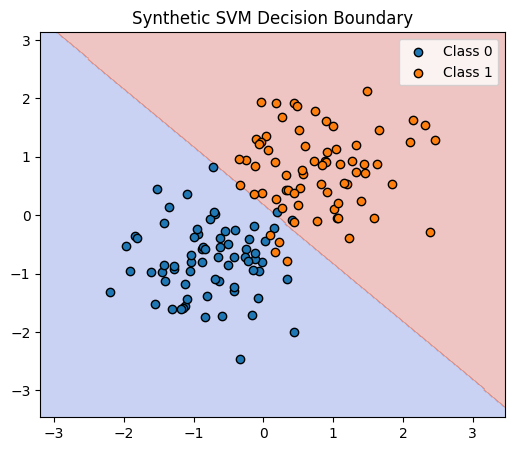

Breast-cancer (2D) SVM accuracy: 88.30%


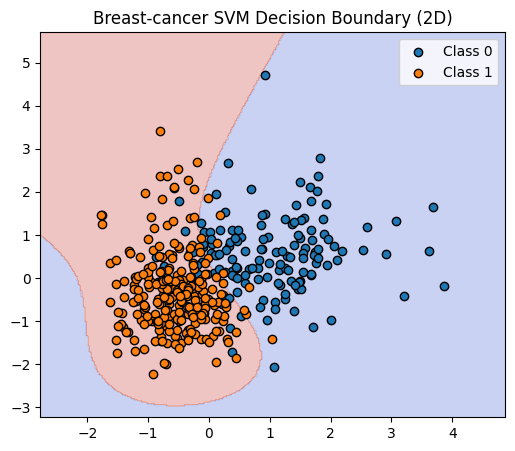

In [ ]:
# Generatting random data
np.random.seed(0)
N_total = 25
X_full = np.random.rand(N_total)
noise_variance = 1 / 25
t_full = np.sin(2 * np.pi * X_full) + np.random.normal(0, np.sqrt(noise_variance), N_total)
X = np.linspace(0, 1, 100)

# basis function obtainined from equation 6.23
def rbf_kernel(x1, x2, signal_variance, length_scale):
    square_dist = (np.subtract.outer(x1, x2))**2
    return signal_variance * np.exp(-0.5 * square_dist / length_scale**2)

# using equation 6.66 and 6.67 in order to make predicitve values
def gp_predict(X_train, y_train, X_pred,
               signal_variance, length_scale, noise_var):
    K = rbf_kernel(X_train, X_train, signal_variance, length_scale)
    K += noise_var * np.eye(len(X_train))
    K_inv = inv(K)
    K_s = rbf_kernel(X_train, X_pred, signal_variance, length_scale)
    mu = K_s.T.dot(K_inv).dot(y_train)
    K_ss = rbf_kernel(X_pred, X_pred, signal_variance, length_scale)
    var = np.maximum(np.diag(K_ss - K_s.T.dot(K_inv).dot(K_s)), 0)
    return mu, np.sqrt(var)

# Plot components in order to produce Figure 3.8 with our obtained values and predictions
# Lets loop through our benchmarks and plot those scenarios
signal_variance = 1.0
length_scale = 0.2
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, N in zip(axes.flatten(), [1, 2, 4, 25]):
    X_train = X_full[:N]
    y_train = t_full[:N]
    mean_pred, std_pred = gp_predict(X_train, y_train, X, signal_variance, length_scale, noise_variance)

    ax.plot(X, np.sin(2 * np.pi * X), color='#1f77b4', linestyle='--', linewidth=2, label='True function')#base sin wave
    ax.plot(X, mean_pred, color='#ff7f0e', linewidth=3, label='GP mean') #Gaussian predicition line
    ax.fill_between(X, mean_pred - std_pred, mean_pred + std_pred, color='#ffbb78', alpha=0.4) #shadded region by one standard deviation away
    ax.scatter(X_train, y_train, facecolors='none', edgecolors='#2ca02c', s=50)#sample points plotted
    ax.set_title(f'N = {N}')
    ax.set_xlim(0, 1)
    ax.set_ylim(-1.5, 1.5)
axes[0, 0].legend(loc='upper right')
plt.tight_layout()
plt.show()



# Prepare Parameter Grid For SVM Grid Search
param_grid = {'C':     [2**i for i in range(-5, 16, 2)], 'gamma': [2**i for i in range(-15, 4, 2)]}

# Creating two different classifications as a start
np.random.seed(0)
N = 100
mu1 = np.array([1, 1])
mu0 = np.array([-1, -1])
X1 = np.random.multivariate_normal(mu1, np.eye(2), N)
X0 = np.random.multivariate_normal(mu0, np.eye(2), N)

#Data set and labels
X_syn = np.vstack((X1, X0))
y_syn = np.hstack((np.ones(N), np.zeros(N)))

# Split into training and test set. This is very similar to the procedure in project 3 so copied the code and adjusted variables
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_syn, y_syn, test_size=0.3, stratify=y_syn, random_state=0)
scaler_s = StandardScaler().fit(X_train_s)
X_train_s = scaler_s.transform(X_train_s)
X_test_s = scaler_s.transform(X_test_s)

# Perform grid search over the hyperparameters
grid_s = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid_s.fit(X_train_s, y_train_s) #training
best_s = grid_s.best_estimator_  #pulling the best estimate of svms
acc_s = accuracy_score(y_test_s, best_s.predict(X_test_s))  #pulling the accuracy of it
print(f'Synthetic SVM accuracy: {acc_s*100:.2f}%')

# Plotting decision boundary and data
xx, yy = np.meshgrid(
    np.linspace(X_train_s[:, 0].min() - 1, X_train_s[:, 0].max() + 1, 300),
    np.linspace(X_train_s[:, 1].min() - 1, X_train_s[:, 1].max() + 1, 300)
)

Z = best_s.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)      # Background by class prediction
plt.scatter(X_train_s[y_train_s == 0, 0], X_train_s[y_train_s == 0, 1], label='Class 0', color='#1f77b4', edgecolors='k')
plt.scatter(X_train_s[y_train_s == 1, 0], X_train_s[y_train_s == 1, 1],label='Class 1', color='#ff7f0e', edgecolors='k')
plt.title('Synthetic SVM Decision Boundary')
plt.legend()
plt.show()

# As before loading in the breast cancer data and formating it
data = load_breast_cancer()
X_bc = data.data[:, :2]
y_bc = data.target
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(X_bc, y_bc, test_size=0.3, stratify=y_bc, random_state=0)
scaler_bc = StandardScaler().fit(X_train_bc)
X_train_bc = scaler_bc.transform(X_train_bc)
X_test_bc = scaler_bc.transform(X_test_bc)

# Once again implementing a grid search in order to find the most effective one and calculating the accuracy of it
grid_bc = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_bc.fit(X_train_bc, y_train_bc)
best_bc = grid_bc.best_estimator_
acc_bc = accuracy_score(y_test_bc, best_bc.predict(X_test_bc))
print(f'Breast-cancer (2D) SVM accuracy: {acc_bc*100:.2f}%')

# Plot Decision Boundary For Breast-Cancer Data
xx_bc, yy_bc = np.meshgrid(
    np.linspace(X_train_bc[:, 0].min() - 1, X_train_bc[:, 0].max() + 1, 300),
    np.linspace(X_train_bc[:, 1].min() - 1, X_train_bc[:, 1].max() + 1, 300)
)
Z_bc = best_bc.predict(np.c_[xx_bc.ravel(), yy_bc.ravel()]).reshape(xx_bc.shape)
plt.figure(figsize=(6, 5))
plt.contourf(xx_bc, yy_bc, Z_bc, cmap='coolwarm', alpha=0.3)  # Shaded regions by predicted class
plt.scatter(X_train_bc[y_train_bc == 0, 0], X_train_bc[y_train_bc == 0, 1], label='Class 0', color='#1f77b4', edgecolors='k')
plt.scatter(X_train_bc[y_train_bc == 1, 0], X_train_bc[y_train_bc == 1, 1],label='Class 1', color='#ff7f0e', edgecolors='k')
plt.title('Breast-cancer SVM Decision Boundary (2D)')
plt.legend()
plt.show()

#Not bad accuracies!!!!